<a href="https://colab.research.google.com/github/luizcalaca/airbnb-cognitive/blob/master/desafio_cognitive_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset utilizado** - 21 January, 2020	Rio de Janeiro listings.csv	Summary - information and metrics for listings in Rio de Janeiro (good for visualisations) link: http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2020-01-21/data/listings.csv.gz.

**Previsão do preço da estadia (feature ‘price’)**

**Análise Exploratória**

In [0]:
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import numpy
import gzip
import seaborn as sns

In [174]:
url = "http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2020-01-21/data/listings.csv.gz"

response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    ds = pd.read_csv(read_file)

print(ds.shape)

(34754, 106)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Retirar as colunas que não fazemm sentido ao problema da predição do valor**

In [0]:
ds = ds.drop(['id', 'listing_url','scrape_id', 'last_scraped', 'name','summary', 'space', 'description', 'neighborhood_overview', 'notes','transit','access','interaction','house_rules',
              'thumbnail_url','medium_url', 'picture_url','xl_picture_url','host_id','host_url','host_name', 'host_about','host_thumbnail_url','host_picture_url', 'host_verifications',
              'calendar_last_scraped','first_review','last_review','license','jurisdiction_names', 'cancellation_policy','zipcode', 'state', 'market', 'smart_location', 'require_guest_profile_picture',
              'require_guest_phone_verification','amenities','security_deposit','calendar_updated', 'country_code','country','smart_location','city','market'], axis=1)

**Verificação da dimensão dos dados (linhas, colunas)**

In [176]:
dim = ds.shape
print(dim)
#print(ds.columns)

(34754, 63)


**Verificação de nulos**

In [177]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34754 entries, 0 to 34753
Data columns (total 63 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   experiences_offered                           34754 non-null  object 
 1   host_since                                    34749 non-null  object 
 2   host_location                                 34577 non-null  object 
 3   host_response_time                            22847 non-null  object 
 4   host_response_rate                            22847 non-null  object 
 5   host_acceptance_rate                          0 non-null      float64
 6   host_is_superhost                             34749 non-null  object 
 7   host_neighbourhood                            22505 non-null  object 
 8   host_listings_count                           34749 non-null  float64
 9   host_total_listings_count                     34749 non-null 

**Acrescentado 0 no lugar de NaN para quem não teve reviews.**

In [178]:
#ds = ds["reviews_per_month"].fillna(0, inplace=True)
ds.tail(5)

,experiences_offered,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,weekly_price,monthly_price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
34749,none,2016-07-23,"Rio de Janeiro, State of Rio de Janeiro, Brazil",NaN,NaN,NaN,f,Copacabana,3.0,3.0,t,f,"Copacabana, RJ, Brazil",Copacabana,Copacabana,NaN,-22.984615,-43.190297,t,Apartment,Private room,2,2.0,1.0,1.0,Real Bed,NaN,$151.00,NaN,NaN,$50.00,1,$85.00,5,1125,5,5,1125,1125,5.0,1125.0,t,29,55,85,360,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,t,f,1,0,1,0,NaN
34750,none,2011-12-13,"Rio de Janeiro, Rio de Janeiro, Brazil",within an hour,100%,NaN,f,Copacabana,42.0,42.0,t,f,"Leblon, Rio de Janeiro, Brazil",Leblon,Leblon,NaN,-22.983637,-43.226884,t,Apartment,Entire home/apt,8,2.5,3.0,1.0,Real Bed,NaN,"$1,930.00",NaN,NaN,$250.00,1,$0.00,5,10,5,5,10,10,5.0,10.0,t,23,53,83,83,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,43,43,0,0,NaN
34751,none,2016-05-03,BR,NaN,NaN,NaN,f,NaN,2.0,2.0,t,f,"Recreio dos Bandeirantes, Rio de Janeiro, Brazil",Recreio dos Bandeirantes,Recreio dos Bandeirantes,NaN,-23.022625,-43.453935,f,Apartment,Entire home/apt,8,3.0,3.0,3.0,Real Bed,NaN,$999.00,NaN,NaN,NaN,1,$0.00,1,20,1,1,20,20,1.0,20.0,t,28,38,62,337,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,1,1,0,0,NaN
34752,none,2019-09-04,BR,within an hour,100%,NaN,f,Laranjeiras,2.0,2.0,t,f,"Rio de Janeiro, RJ, Brazil",Laranjeiras,Laranjeiras,NaN,-22.937010,-43.183044,t,Apartment,Private room,2,1.5,1.0,0.0,Real Bed,NaN,$92.00,NaN,NaN,NaN,1,$65.00,1,15,1,1,15,15,1.0,15.0,t,29,52,82,172,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,2,0,2,0,NaN
34753,none,2019-02-20,"State of Rio de Janeiro, Brazil",within an hour,100%,NaN,f,NaN,7.0,7.0,t,f,"Copacabana, Rio de Janeiro, Brazil",Copacabana,Copacabana,NaN,-22.963840,-43.181151,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$180.00,NaN,NaN,$150.00,1,$0.00,3,1125,3,3,1125,1125,3.0,1125.0,t,28,58,88,363,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,1,0,1,0,NaN


**Remoção de campos com alta porcentagem de 30% ou menos de nulos**

In [179]:
df2 = ds[[column for column in ds if ds[column].count() / len(ds) >= 0.3]]
#del df2['Id']
print("List of dropped columns:", end=" ")
for c in ds.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
ds = df2

List of dropped columns: host_acceptance_rate, neighbourhood_group_cleansed, square_feet, weekly_price, monthly_price, 



**Remoção do símbolo de valor monetório (dólar)**

In [180]:
ds.dtypes

experiences_offered                              object
host_since                                       object
host_location                                    object
host_response_time                               object
host_response_rate                               object
host_is_superhost                                object
host_neighbourhood                               object
host_listings_count                             float64
host_total_listings_count                       float64
host_has_profile_pic                             object
host_identity_verified                           object
street                                           object
neighbourhood                                    object
neighbourhood_cleansed                           object
latitude                                        float64
longitude                                       float64
is_location_exact                                object
property_type                                   

In [0]:
def remove_simbolo_monetario(x):
    a =  x[1:] #remove apenas um caracter
    result = ""
    for i in a:
        if i.isdigit() is True:
            result = result + i
    return result #retorna os digíto, sem o símbolo

In [0]:
ds["price"] = pd.to_numeric(ds["price"].apply(remove_simbolo_monetario), errors= "ignore")
ds["extra_people"] = pd.to_numeric(ds["extra_people"].apply(remove_simbolo_monetario), errors= "ignore")

In [0]:
#ds = ds["security_deposit"].fillna(0)

In [0]:
#ds["cleaning_fee"] = pd.to_numeric(ds["cleaning_fee"].apply(remove_simbolo_monetario), errors= "ignore")
#ds["security_deposit"] = pd.to_numeric(ds["security_deposit"].apply(remove_simbolo_monetario), errors= "ignore")

**Transformamdo algumas colunas categóricas para a representação numérica.**

In [0]:
ds['bed_type'] = ds.bed_type.astype('category')
ds['bed_type'].cat.categories
ds['bed_type'] = ds['bed_type'].cat.codes

In [0]:
ds['property_type'] = ds.property_type.astype('category')
ds['property_type'].cat.categories
ds['property_type'] = ds['property_type'].cat.codes

In [0]:
ds['room_type'] = ds.room_type.astype('category')
ds['room_type'].cat.categories
ds['room_type'] = ds['room_type'].cat.codes

In [0]:
ds["instant_bookable"] = ds.instant_bookable.astype('category')
ds["instant_bookable"].cat.categories
ds["instant_bookable"] = ds['instant_bookable'].cat.codes


**Verificação e remoção de outliers**

(34754, 58)

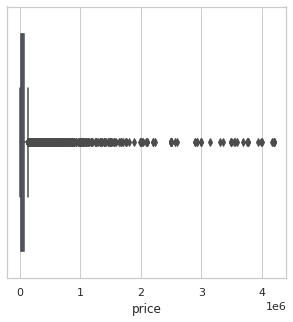

In [189]:
plt.figure(figsize = (5,5))
sns.boxplot(ds["price"])
ds.shape

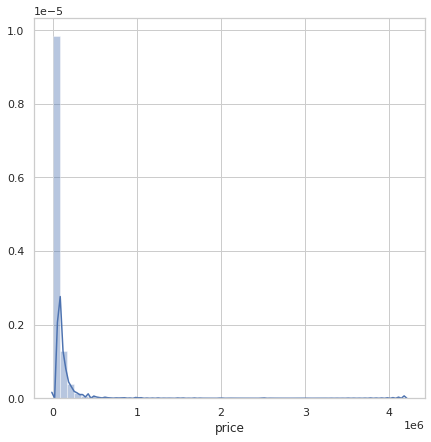

In [190]:
plt.figure(figsize = (7,7))
sns.set(style = "whitegrid")
f = sns.distplot(ds["price"])

In [0]:
q1 = ds["price"].quantile(0.25)
q3 = ds["price"].quantile(0.75)

IQR = q3 - q1
IF = q1 - (1.5 * IQR)
OF = q3 + (1.5 * IQR)

In [192]:
ds = ds[~((ds["price"] < IF) | (ds["price"] > OF))]
ds.shape

(31471, 58)

**Distribuição price após a retirada de outliers**

count     31471.000000
mean      35735.887007
std       28562.490524
min           0.000000
25%       15100.000000
50%       25200.000000
75%       49500.000000
max      126700.000000
Name: price, dtype: float64


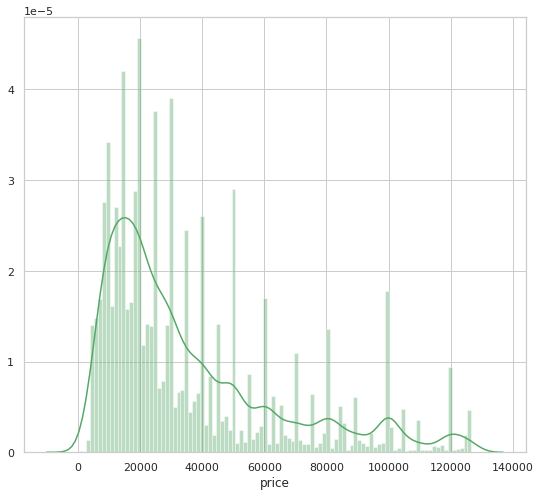

In [193]:
print(ds['price'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(ds['price'], color='g', bins=100, hist_kws={'alpha': 0.4});

**Verificando os tipos númericos existentes**

In [194]:
list(set(ds.dtypes.tolist()))

[dtype('float64'), dtype('int8'), dtype('O'), dtype('int64')]

**Selecionando somente os tipos númericos e verificando a distribuição de seus dados**

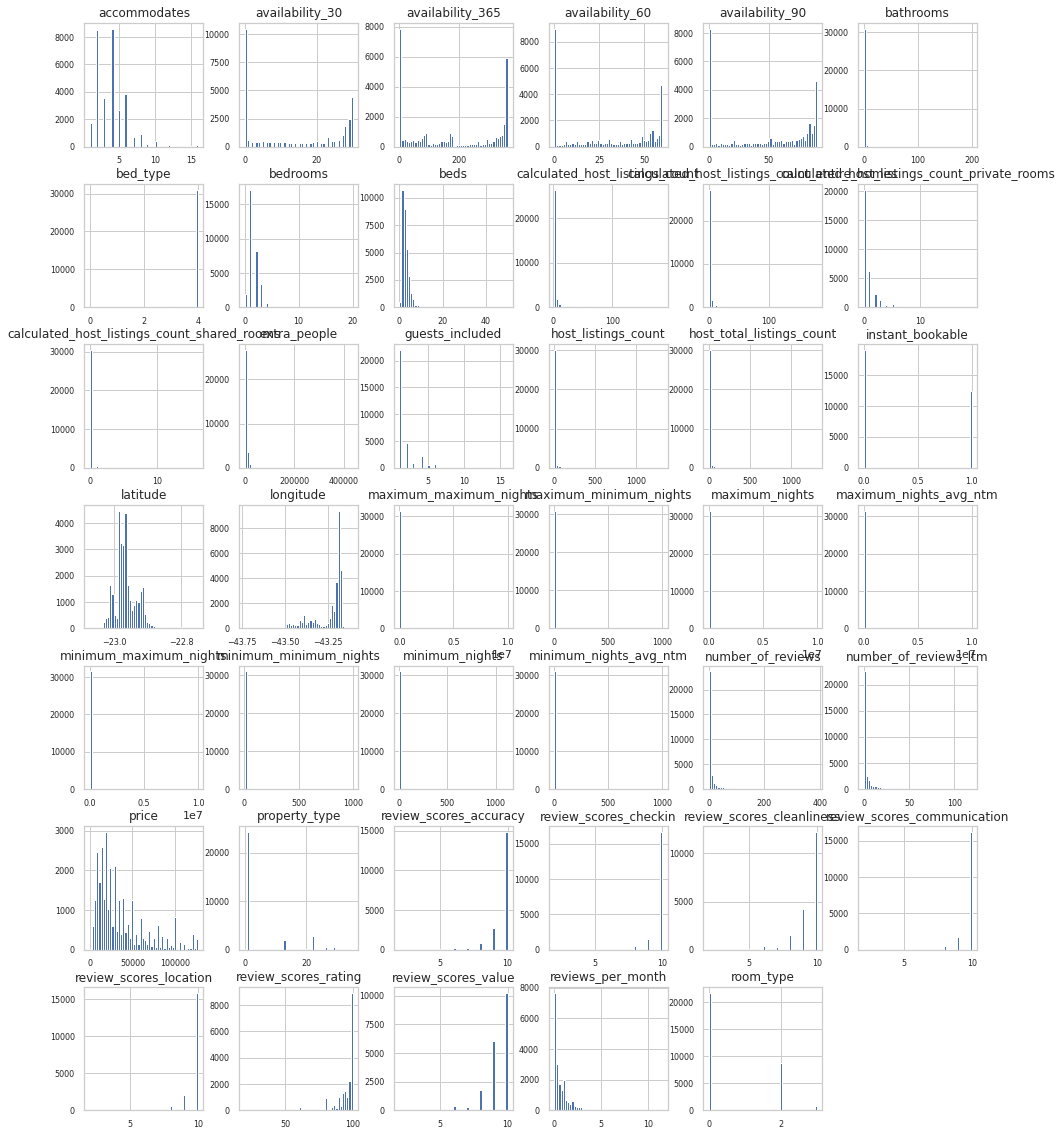

In [195]:
df_num = ds.select_dtypes(include = ['float64', 'int64', 'int8'])

df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

**Verificação de correlação entre as variávies e a price. Quais variávies impactam no valor do imóvel?**

In [196]:
df_num_corr = df_num.corr()['price'][:-1] # -1 pois a última linha é a Price
golden_features_list = df_num_corr[abs(df_num_corr) > 0.1].sort_values(ascending=False)
print("There is {} strongly correlated values with price:\n{}".format(len(golden_features_list), golden_features_list))

There is 12 strongly correlated values with price:
price                                           1.000000
bedrooms                                        0.436359
accommodates                                    0.390812
beds                                            0.255648
bathrooms                                       0.222481
guests_included                                 0.104676
longitude                                      -0.131013
number_of_reviews                              -0.169648
calculated_host_listings_count_private_rooms   -0.178112
latitude                                       -0.183757
number_of_reviews_ltm                          -0.197525
room_type                                      -0.327253
Name: price, dtype: float64


** Correlação entre as variáveis **

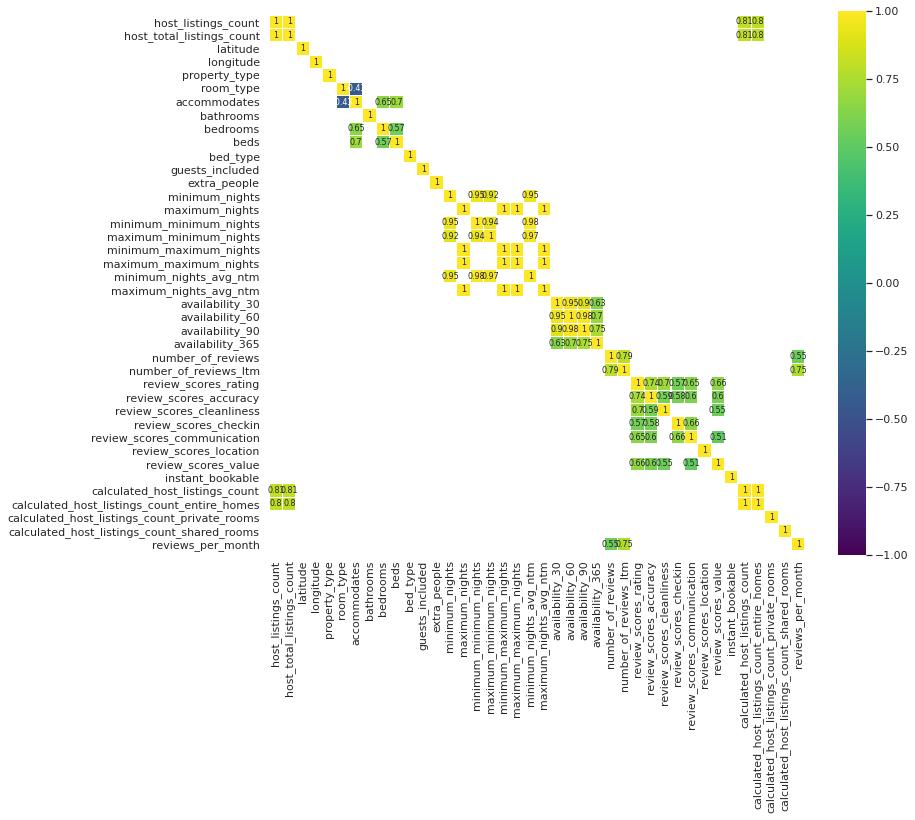

In [197]:
import seaborn as sns

corr = df_num.drop('price', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

**Observando a distribuição de dados de cada coluna numérica em relação à price**

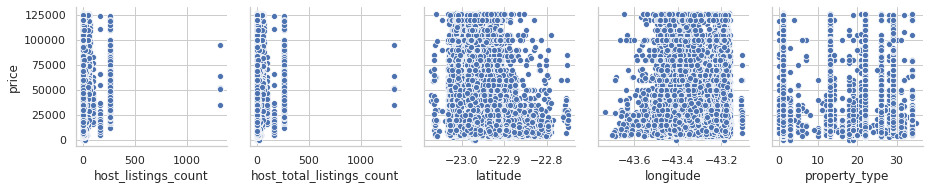

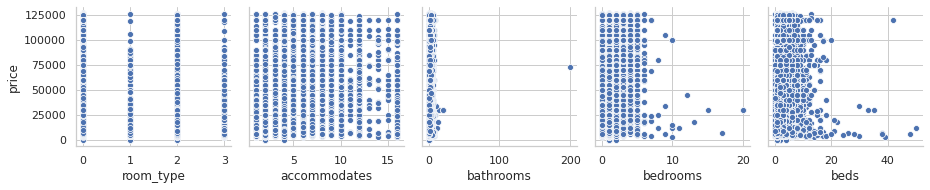

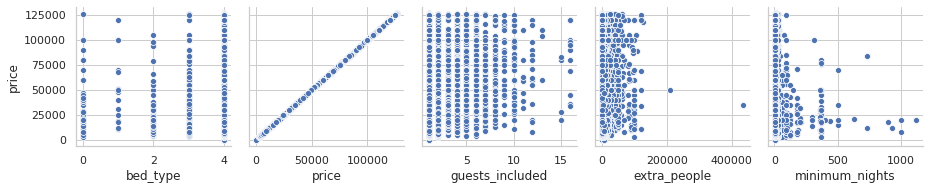

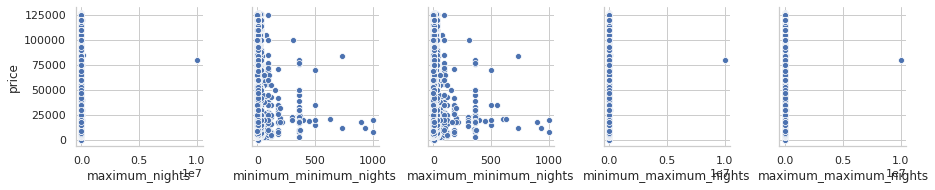

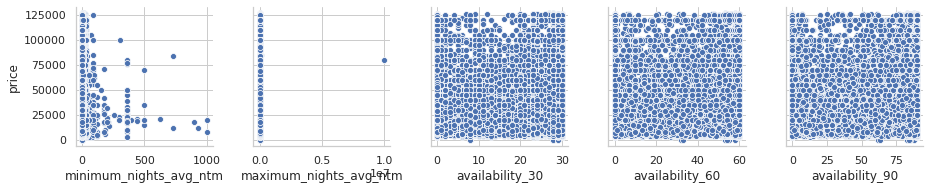

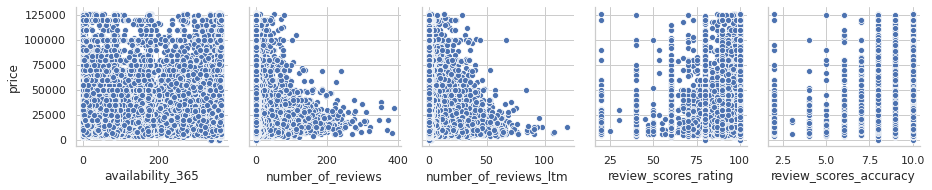

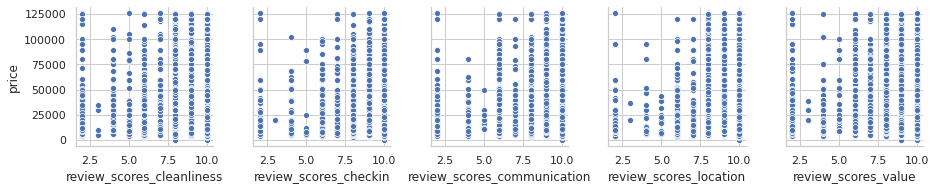

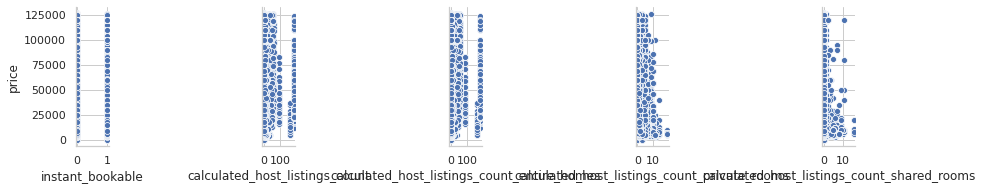

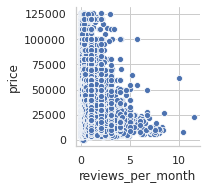

In [198]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['price'])

**Escolha de algumas variáveis a partir da correlação**

In [199]:
ds["accommodates"] = pd.to_numeric(ds["accommodates"], errors= "ignore")
ds["bathrooms"] = pd.to_numeric(ds["bathrooms"], errors= "ignore")
ds["bedrooms"] = pd.to_numeric(ds["bedrooms"], errors= "ignore")
ds["beds"] = pd.to_numeric(ds["beds"], errors= "ignore")
ds["room_type"] = pd.to_numeric(ds["room_type"], errors= "ignore")

ds["review_scores_location"] = pd.to_numeric(ds["review_scores_location"], errors= "ignore")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [0]:
#ds = ds.replace(numpy.nan, 0.0001)
#ds = ds.replace(0, 0.0001)
ds = ds.dropna()

**Colunas do treinamento e a label price procurada**

In [0]:
#x = ds.drop("price", axis = 1)
#columns = ['review_score_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location']
x = ds[['accommodates', 'bathrooms','bedrooms','beds','room_type']]
y = ds["price"]

In [202]:
x.isnull().any()
x.shape

(10194, 5)

In [203]:
y.isnull().any()
y.shape

(10194,)

In [204]:
x

,accommodates,bathrooms,bedrooms,beds,room_type
0,5,1.0,2.0,2.0,0
1,6,2.0,2.0,4.0,0
2,2,1.0,1.0,2.0,0
3,3,1.0,1.0,2.0,0
4,2,1.5,1.0,1.0,0
...,...,...,...,...,...
34146,4,1.0,1.0,1.0,0
34171,2,1.0,1.0,1.0,0
34203,4,1.0,1.0,4.0,0
34246,2,1.0,1.0,2.0,2


**Separação dos conjunto de treinamento e teste**

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

# rkf.split(X)
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30)
#random_state = 12883823
#rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
#x_train, x_test,y_train,y_test = rkf.split(x)

Aplicação do **Regressão Linear**

In [206]:
#from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#rf = RandomForestRegressor(n_estimators = 1500, verbose=1, criterion='mse')
rf = linear_model.LinearRegression()
rf.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [207]:
x_test

,accommodates,bathrooms,bedrooms,beds,room_type
801,2,1.0,1.0,1.0,0
20266,5,3.0,3.0,4.0,0
19836,5,2.0,2.0,2.0,0
7972,4,1.0,1.0,2.0,0
23962,2,1.0,1.0,1.0,0
...,...,...,...,...,...
7782,4,2.0,2.0,2.0,0
9156,3,1.0,1.0,1.0,0
31409,5,1.5,3.0,3.0,0
7421,2,1.0,1.0,1.0,2


**Predição**

In [0]:
pred = rf.predict(x_test)

In [209]:
print("Conjunto de predições:\n {}".format(pred))

Conjunto de predições:
 [22337.83080177 48966.72062902 38615.21376909 ... 41410.43109525
 12983.58626019 38021.81504857]


In [210]:

# coeficientes
print('Coeficientes: \n', rf.coef_)
# mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, pred))
# Coeficiente de determinação: 1 é a predição perfeita
print('Coeficiente de determinação: %.2f'
      % r2_score(y_test, pred))

Coeficientes: 
 [ 1608.33621347  5771.43800051  6781.80379341 -1100.867467
 -4677.12227079]
Mean squared error: 325696861.61
Coeficiente de determinação: 0.37


In [211]:
pred.shape

(3059,)

In [212]:
x_test.shape

(3059, 5)

In [213]:
y_test.shape

(3059,)

**Plotagem da regressão**

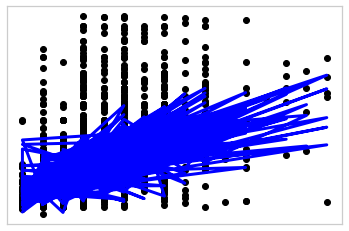

In [214]:
plt.scatter(x_test['accommodates'], y_test,  color='black')
plt.plot(x_test['accommodates'], pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

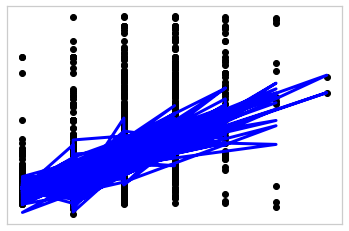

In [215]:
plt.scatter(x_test['bedrooms'], y_test,  color='black')
plt.plot(x_test['bedrooms'], pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

**Salvando o modelo**

In [216]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(rf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.366314055431252
